## Installing relevant modules for this task

In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

## Loading the data to be used for training the chatbot.

In [ ]:
from datasets import load_dataset, DatasetDict
import pandas as pd

# Load the dataset directly from the Hugging Face Hub
sgd_hotels = load_dataset("vidhikatkoria/SGD_Hotels", split='train')

print("Hotels features:", sgd_hotels.features)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/570 [00:00<?, ?B/s]

(…)-00000-of-00001-0225aaf39f8f1eab.parquet:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

(…)-00000-of-00001-b98de524a3870f93.parquet:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Hotels features: {'domain': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'response': Value(dtype='string', id=None), 'act': Value(dtype='int64', id=None), 'speaker': Value(dtype='int64', id=None)}


## Preprocessing the data.

In [ ]:
import pandas as pd

# Extract user responses
def extract_user_responses(batch):
    user_texts = []
    user_acts = []

    for response, act, speaker in zip(
        batch['response'], batch['act'], batch['speaker']
    ):
        if speaker == 0:  # Only process user responses
            cleaned_text = response.strip()
            if cleaned_text:  # Only add non-empty responses
                user_texts.append(cleaned_text)
                user_acts.append(act)

    return {
        'text': user_texts,
        'act': user_acts,
    }

# Processing dataset
hotels_clean = sgd_hotels.map(extract_user_responses, batched=True, remove_columns=sgd_hotels.column_names)
df = hotels_clean.to_pandas()

print("Unique intents:", df["act"].unique())
print(df.head())

Map:   0%|          | 0/12520 [00:00<?, ? examples/s]

Unique intents: [ 3  2 11 14  1  0 10 13  4  5]
   act                                               text
0    3          I am plannning a trip to London, England.
1    2  Okay, this house sounds amazing. That's all I ...
2   11                         Do you have anything else?
3   14                             No, you've been great.
4    2                               Thanks. I've got it.


act
3     2143
14     901
10     795
1      619
4      583
13     492
11     384
2      360
0      187
5       44
Name: count, dtype: int64


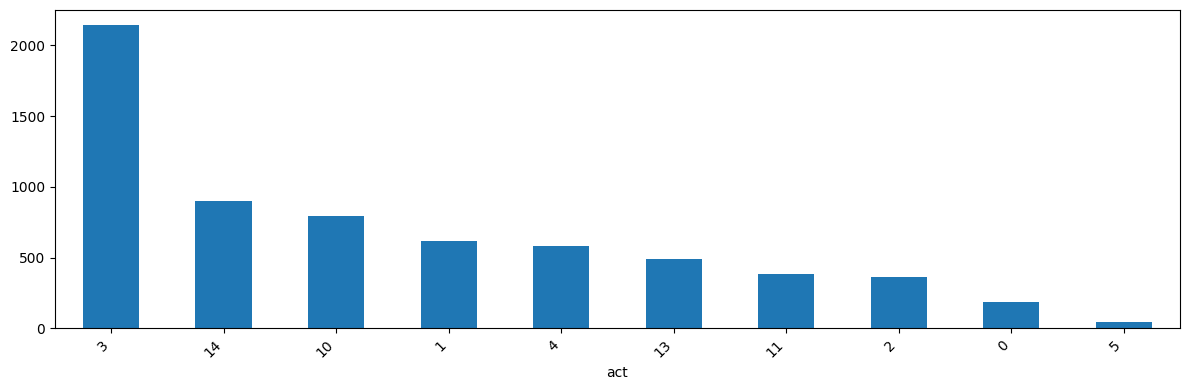

In [ ]:
intent_counts = df['act'].value_counts()
print(intent_counts)

# Visualize intent distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
intent_counts.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Checking the text that corresponds with each intent
for intent in df['act'].unique():
    samples = df[df['act'] == intent]['text'].sample(min(5, len(df[df['act'] == intent])), random_state=42) # Gets 5 samples per intent
    print(f"\nIntent {intent} examples:")
    for sample in samples:
        print(f"- {sample[:80]}")


Intent 3 examples:
- In SFO.
- Great, book that for the 8th please?
- Make it next Monday.
- What else is there? Also, I need to be able to have pets stay with me.
- only one day.

Intent 2 examples:
- Thank you so much, I'm all set.
- i appreciate your help, Thank you. I don't need anything else.
- No, not now.That's all now.
- Thank you for your help.
- I like it, thanks. Bye

Intent 11 examples:
- Anything else you have, I am searching for one person and the rating 4.2 or high
- Any other options?
- Hmm. Check for some other hotel, please, one that allows pets. I need to reserve
- Anything else available?
- Are there any other hotel available?

Intent 14 examples:
- No, that's all
- Thank you very much for your help
- Nothing, I am very thankful.
- Thank you.
- Thank you for your time.

Intent 1 examples:
- Sounds great, what's the price?
- Confirmed. What's the price and rating?
- That is correct.
- Approval granted, thanks.
- That suits me well. Can you tell me how much it will c

intent_name
MakeBooking             3441
ThankYou                1261
RequestAmenitiesInfo     795
DeclineBooking           627
RequestOtherHotel        384
Name: count, dtype: int64


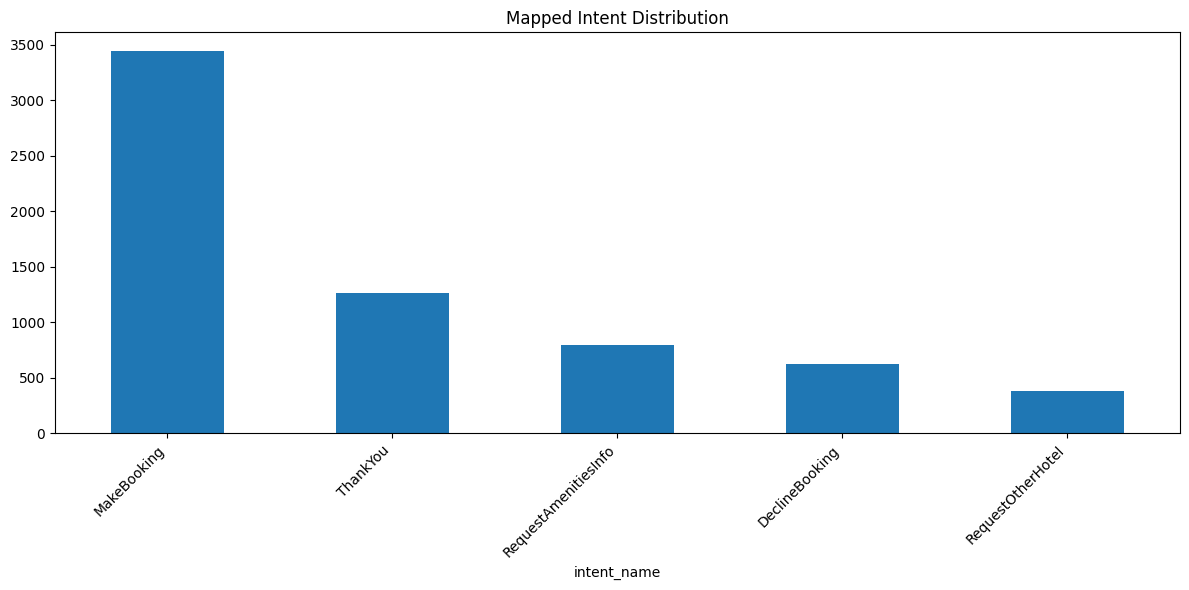

In [ ]:
# Mapping act numbers to intents
intent_mapping = {
    0: "MakeBooking",
    1: "MakeBooking",
    2: "ThankYou",
    3: "MakeBooking",
    4: "DeclineBooking",
    5: "DeclineBooking",
    10: "RequestAmenitiesInfo",
    11: "RequestOtherHotel",
    13: "MakeBooking",
    14: "ThankYou"
}

df['intent_name'] = df['act'].map(intent_mapping)

# Verify new distribution
new_counts = df['intent_name'].value_counts()
print(new_counts)

# Visualize new distribution
plt.figure(figsize=(12,6))
new_counts.plot(kind='bar')
plt.title("Mapped Intent Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Step 1: Split the dataframe (stratified by intent_name)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['intent_name']
)

# Step 2: Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Step 3: Wrap in a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

## Setting up model parameters

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, BertTokenizer, Trainer
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import numpy as np
import torch


# 1. Load the tokenizer correctly
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# 3. Encode string labels into integers
le = LabelEncoder()
train_labels = le.fit_transform(tokenized_dataset['train']['intent_name'])
test_labels = le.transform(tokenized_dataset['test']['intent_name'])

# 4. Add numeric labels to the dataset
tokenized_dataset = tokenized_dataset.map(
    lambda x: {'labels': le.transform(x['intent_name'])},
    batched=True
)

# 5. Compute class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weight_tensor = torch.tensor(class_weights, dtype=torch.float)

# 6. Create a weighted dataset wrapper
class WeightedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.weights = [class_weight_tensor[int(label)].item() for label in dataset['labels']]

    def __getitem__(self, idx):
        item = {k: self.dataset[idx][k] for k in self.dataset[idx].keys()}
        item["weight"] = self.weights[idx]
        item["labels"] = int(self.dataset[idx]['labels'])  # Required for Hugging Face Trainer
        return item

    def __len__(self):
        return len(self.dataset)

weighted_train_dataset = WeightedDataset(tokenized_dataset["train"])
weighted_test_dataset = WeightedDataset(tokenized_dataset["test"])

# 7. Custom Trainer to support class weights
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.args.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 8. Evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'macro_f1': f1_score(p.label_ids, preds, average='macro'),
        'micro_f1': f1_score(p.label_ids, preds, average='micro'),
        'weighted_f1': f1_score(p.label_ids, preds, average='weighted')
    }

# 9. ID , Label mapping
id2label = {i: label for i, label in enumerate(le.classes_)}
label2id = {label: i for i, label in enumerate(le.classes_)}

# 10. Model initialization
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(classes),
    id2label=id2label,
    label2id=label2id
)

# 11. Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    eval_strategy='steps',
    eval_steps=50,
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    greater_is_better=True,
    report_to='none'
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/5206 [00:00<?, ? examples/s]

Map:   0%|          | 0/1302 [00:00<?, ? examples/s]

Map:   0%|          | 0/5206 [00:00<?, ? examples/s]

Map:   0%|          | 0/1302 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training the model

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=weighted_train_dataset,
    eval_dataset=weighted_test_dataset,
    compute_metrics=compute_metrics # Using the F1 metrics function
)

trainer.train()

Step,Training Loss,Validation Loss,Macro F1,Micro F1,Weighted F1
50,0.944700,0.570818,0.625905,0.775730,0.756111
100,0.532500,0.452828,0.706283,0.782642,0.785479
150,0.495900,0.438528,0.732218,0.806452,0.797384
200,0.384700,0.375442,0.646200,0.801843,0.766230
250,0.403700,0.377446,0.656827,0.794163,0.763191
300,0.400200,0.431484,0.604921,0.791859,0.743836
350,0.401700,0.371779,0.660677,0.799539,0.765006
400,0.359700,0.400807,0.753137,0.809524,0.808359
450,0.354100,0.444993,0.605408,0.790323,0.744530
500,0.376600,0.371235,0.714147,0.785714,0.787184


TrainOutput(global_step=1630, training_loss=0.35293221853993423, metrics={'train_runtime': 1119.459, 'train_samples_per_second': 23.252, 'train_steps_per_second': 1.456, 'total_flos': 1712241312084480.0, 'train_loss': 0.35293221853993423, 'epoch': 5.0})

## Evaluating and saving the trained model

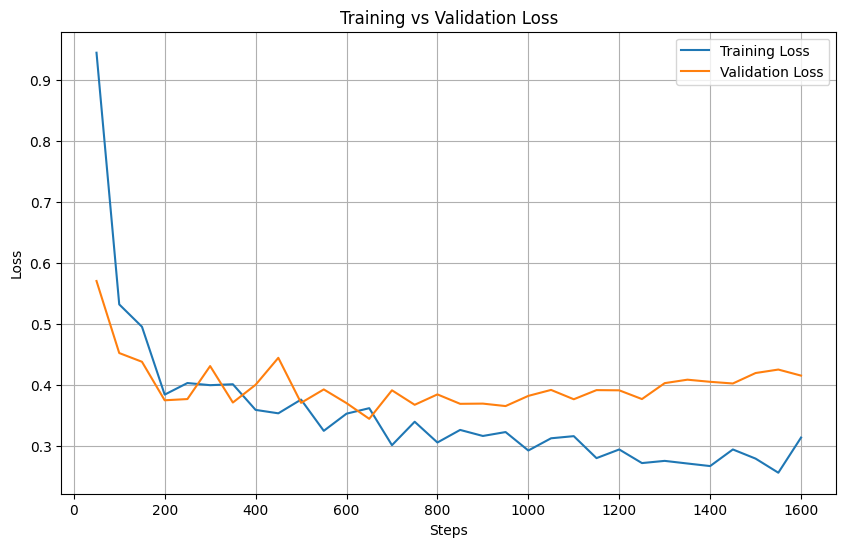

In [ ]:
# Get training history
history = trainer.state.log_history

# Convert to DataFrame
df_history = pd.DataFrame(history)

# Clean and plot
train_loss = df_history[df_history['loss'].notna()]
eval_loss = df_history[df_history['eval_loss'].notna()]

plt.figure(figsize=(10, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.savefig('post_training_loss.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Obtaining classification report for model evaluation
predictions = trainer.predict(tokenized_dataset['test'])
preds = np.argmax(predictions.predictions, axis=1)

print("\nClassification Report:")
print(classification_report(
    predictions.label_ids,
    preds,
    target_names=list(id2label.values()), # Now id2label is globally available
    zero_division=0
))


Classification Report:
                      precision    recall  f1-score   support

      DeclineBooking       0.46      0.74      0.56       126
         MakeBooking       0.84      0.81      0.83       688
RequestAmenitiesInfo       0.71      0.75      0.73       159
   RequestOtherHotel       0.61      0.56      0.58        77
            ThankYou       0.90      0.68      0.77       252

            accuracy                           0.76      1302
           macro avg       0.70      0.71      0.69      1302
        weighted avg       0.78      0.76      0.76      1302



In [ ]:
# Saving the model
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json')

## Testing the model

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "./trained_model"  # Your saved model directory
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
import pandas as pd
import torch

def predict_intent_table(test_texts, return_confidence=True):
    """
    Predict intents for multiple texts and return results in a table format.

    Args:
        test_texts (list): List of text strings to predict
        return_confidence (bool): Whether to include confidence scores

    Returns:
        pd.DataFrame: Table with columns 'text', 'predicted_intent', and 'confidence'
    """
    results = []

    for text in test_texts:
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)

        # Convert to probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        top_prob, top_label = torch.max(probs, dim=1)

        # Get intent name and confidence
        intent = model.config.id2label[top_label.item()]
        confidence = top_prob.item()

        results.append({
            'text': text,
            'predicted_intent': intent,
            'confidence': confidence
        })

    # Create dataframe and format confidence as percentage
    df = pd.DataFrame(results)
    if return_confidence:
        df['confidence'] = df['confidence'].apply(lambda x: f"{x:.1%}")

    return df

In [ ]:
# Test with sample texts
test_samples = [
    # MakeBooking
    "Please book that room for me.",
    "Yes, I'd like to reserve the hotel for the 10th.",
    "Go ahead and confirm that, it looks perfect.",

    # ThankYou
    "Thanks a lot for your help!",
    "I really appreciate the assistance. That's all I needed.",
    "Thank you, have a great day!",

    # RequestAmenitiesInfo
    "Does this hotel provide Wi-Fi?",
    "Is there a pool or a gym in the building?",
    "Can I get information on parking availability?",

    # DeclineBooking
    "No, I don’t want to book right now.",
    "Never mind, I’ll take care of it later.",
    "Actually, I’m not interested anymore. Thanks anyway.",

    # RequestOtherHotel
    "Do you have any other hotel options?",
    "Can you show me something else in the same area?",
    "That doesn’t work for me — what else is available?"
]

results = predict_intent_table(test_samples)
print(results)

                                                 text      predicted_intent  \
0                       Please book that room for me.           MakeBooking   
1    Yes, I'd like to reserve the hotel for the 10th.           MakeBooking   
2        Go ahead and confirm that, it looks perfect.           MakeBooking   
3                         Thanks a lot for your help!              ThankYou   
4   I really appreciate the assistance. That's all...              ThankYou   
5                        Thank you, have a great day!              ThankYou   
6                      Does this hotel provide Wi-Fi?  RequestAmenitiesInfo   
7           Is there a pool or a gym in the building?  RequestAmenitiesInfo   
8      Can I get information on parking availability?  RequestAmenitiesInfo   
9                 No, I don’t want to book right now.        DeclineBooking   
10            Never mind, I’ll take care of it later.        DeclineBooking   
11  Actually, I’m not interested anymore. Thanks a..

In [ ]:
# DeclineBooking intent testing (worst performing category)
decline_booking_samples = [
    "No, I don't want to book anything right now.",
    "Actually, I’ll pass for now. Thanks though.",
    "Not today, thank you.",
    "I’m not ready to make a reservation.",
    "I’ll think about it and book later.",
    "That won’t work for me.",
    "No need to continue, I’ve changed my mind.",
    "Thanks, but I won’t be booking at this time.",
    "I’m going to skip this one.",
    "Let me decide later. No booking for now.",
    "I’ve decided not to book anything right now.",
    "I’m not interested in booking anymore.",
    "No thanks, I’ll handle it myself.",
    "I won’t go ahead with the booking after all.",
    "I’ll hold off on booking for now.",
    "Please cancel that — I’ve reconsidered.",
    "I’ll book something on my own later.",
    "That’s all for now, no need to proceed.",
    "I’m not booking anything at this point.",
    "No, I’m good. No reservation needed."
]

results = predict_intent_table(decline_booking_samples)
print(results)

                                            text predicted_intent confidence
0   No, I don't want to book anything right now.   DeclineBooking      78.9%
1    Actually, I’ll pass for now. Thanks though.   DeclineBooking      55.6%
2                          Not today, thank you.   DeclineBooking      62.9%
3           I’m not ready to make a reservation.   DeclineBooking      65.0%
4            I’ll think about it and book later.      MakeBooking      99.5%
5                        That won’t work for me.   DeclineBooking      78.8%
6     No need to continue, I’ve changed my mind.   DeclineBooking      69.9%
7   Thanks, but I won’t be booking at this time.         ThankYou      86.2%
8                    I’m going to skip this one.      MakeBooking      63.3%
9       Let me decide later. No booking for now.   DeclineBooking      77.0%
10  I’ve decided not to book anything right now.   DeclineBooking      78.9%
11        I’m not interested in booking anymore.   DeclineBooking      80.8%